In [18]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.io import fits
import healpy as hp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from astropy import wcs
import astropy.units as u
import matplotlib as mpl
import os
from astropy.cosmology import Planck15 as cosmo, z_at_value
from scipy import ndimage
import corner 
import coop_post_processing as cpp
# set plot params
mpl.font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 3}
plt.rcParams.update({'font.size': 10})


In [2]:
def ThetaPhitoDeclRa(theta,phi):
    dec = -1*np.degrees(theta)+90
    ra  = np.degrees(phi)
    if ra>180:
        ra = -360+ra
    return dec,ra

def get_x_e(e_filename, ra, dec, mask):
    ecc_map0 = hp.read_map(e_filename, field=0)
    ecc_map1 = hp.read_map(e_filename, field=1)    
    ecc_map2 = hp.read_map(e_filename, field=2)
    
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    e  = np.sqrt((ecc_map1**2 + ecc_map2**2)/(2*ecc_map0**2))
    #ecc_map0 = del^2(F)
    mean_del2 = sum(ecc_map0*mask)/sum(mask)
    rms_2 = np.sqrt(sum((ecc_map0-mean_del2)**2*mask)/sum(mask))
    hp.mollview(ecc_map0)
    print("mean of del^2(F) = ", mean_del2)
    print("rms of del^2(F)  = ", rms_2)
    x = ecc_map0*mask / rms_2
    print("Map of x = del^2(F)")
    hp.mollview(x)
    return e[pixels], x[pixels]

def get_nu(od_filename, ra, dec, mask):
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    od_map = read_amp_map(od_filename)
    mean_od = sum(od_map*mask)/sum(mask)
    rms = np.sqrt(sum((od_map-mean_od)**2*mask)/sum(mask))
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    nu = ((od_map-mean_od)*mask) / rms
    hp.mollview(nu)
    return(nu[pixels])

def get_nu_map(od_map, mask):
    mean_od = sum(od_map*mask)/sum(mask)
    rms = np.sqrt(sum((od_map-mean_od)**2*mask)/sum(mask))
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    nu = ((od_map-mean_od)*mask) / rms
    return(nu)

def map_to_overdensity(map, mask):
    map_mean = sum(map*mask)/sum(mask)
    print("map mean before: ", map_mean)
    omap = map/map_mean - 1
    print("map mean after: ", sum(omap*mask)/sum(mask))
    return omap*mask

def nu_custom_scale(od_map_file, fwhm, ra, dec, mask):
    od_map = hp.read_map(od_map_file)
    od_map_smth = hp.smoothing(od_map, fwhm=(fwhm.to(u.rad)).value, pol=False)
    pixels = hp.ang2pix(nside, ra, dec, lonlat=True)
    mean_od = sum(od_map_smth*mask)/sum(mask)
    rms = np.sqrt(sum((od_map_smth-mean_od)**2*mask)/sum(mask))
    print("rms = ", rms)
    print("mean of overdensity map = ", mean_od)
    nu = ((od_map_smth-mean_od)*mask) / rms
    hp.mollview(nu)
    return(nu[pixels])

def get_peakinfo(filename):
    peakfile = fits.open(filename)
    peakinfo = peakfile[0].data
    rot_angle = peakinfo[:,3]
    theta,phi = peakinfo[:,1], peakinfo[:,2]
    dec = []
    ra  = []
    for i in range(len(theta)):
        dec.append(ThetaPhitoDeclRa(theta[i],phi[i])[0])
        ra.append(ThetaPhitoDeclRa(theta[i],phi[i])[1])

    ra = np.asarray(ra)
    dec = np.asarray(dec)
#     in_region = (ra>pt_lonmin) & (ra < pt_lonmax) & (dec < pt_latmax) & (dec > pt_latmin)
#     dec = dec[in_region]
#     rot_angle = rot_angle[in_region]
#     ra = ra[in_region]
    return (rot_angle,ra,dec)
    peakfile.close()
    

def get_vector_components(rot_angle):
    U_arr = np.zeros(len(rot_angle))
    V_arr = np.zeros(len(rot_angle))
    m = 0
    for r in rot_angle:

        if (r <= np.pi/2.) or (r > 3*np.pi/2.):
            U = 1/np.sqrt(1+np.tan(r)**2)
        else:
            U = -1/np.sqrt(1+np.tan(r)**2)
        V = U * np.tan(r)
        U_arr[m] = U
        V_arr[m] = V
        m += 1
    return U_arr, V_arr

def read_amp_map(amp_file):
    amp_map = fits.open(amp_file)
    amp_map[1].header['TTYPE3'] = 'ID2'
    amp_map.writeto(amp_file, overwrite=True)
    amp_map.close()
    return hp.read_map(amp_file, field=0)

def get_od_map(nside, theta, phi, mask, smth):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside,theta,phi)
    weight = 1.
    np.add.at(map, pix, weight)
    masked_map = map * mask
    mean = sum(masked_map)/sum(mask)
    newmap   = map/mean - 1
    newmap_masked = newmap * mask
    print("Mean of number density map: ", mean)
    print("Mean of overdensity map: ", sum(newmap_masked)/sum(mask))
    if smth != 0:
        smoothed_map = hp.sphtfunc.smoothing(halomap, fwhm = np.deg2rad(smth_scale_arcsec.value/3600.), pol=False)
    else:
        smthmap = newmap
    return newmap_masked

def get_nd_map(nside, theta, phi, mask, smth_arcmin):
    map   = np.zeros((hp.nside2npix(nside)))
    pix = hp.ang2pix(nside,theta,phi)
    weight = 1.
    np.add.at(map, pix, weight)
    masked_map = map * mask
    mean = sum(masked_map)/sum(mask)
    print("Mean of number density map: ", mean)
    if smth_arcmin != 0:
        smthmap = hp.sphtfunc.smoothing(masked_map, fwhm = np.deg2rad(smth_arcmin/60.), pol=False)
    else:
        smthmap = masked_map
    return smthmap, mean



Choose a slice

In [4]:
slice_min = 1232
slice_max = 1432

In [5]:
od_map_smth = read_amp_map("/mnt/raid-cita/mlokken/buzzard/number_density_maps/des_reg/odmap_distMpc_{:d}_{:d}_0Mpc_0arcmin_AMPLITUDE_fwhm35a.fits".format(slice_min, slice_max))
mask = hp.read_map("/mnt/raid-cita/mlokken/data/redmagic/y3_gold_2.2.1_wide_sofcol_run_redmapper_v6.4.22_redmagic_highdens_0.5_vlim_zmask_hpx.fit")

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Get $\nu$ map

In [6]:
nu_map = get_nu_map(od_map_smth, mask)

rms =  0.3686296722316251
mean of overdensity map =  -0.0011698875778558332


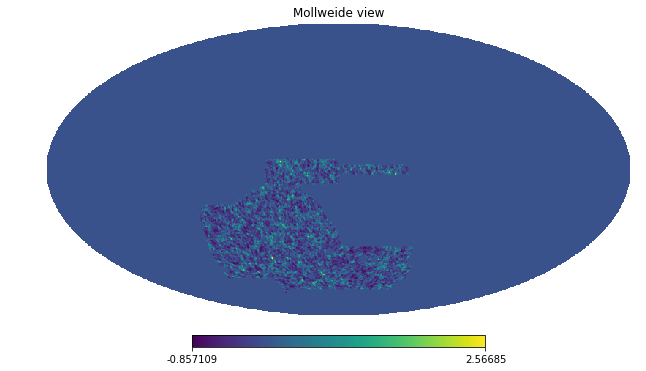

In [7]:
hp.mollview(od_map_smth)

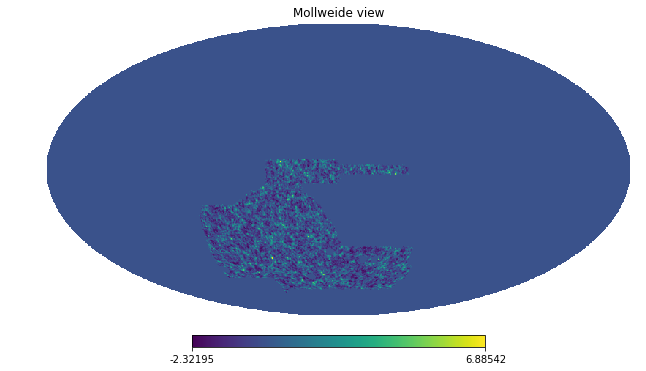

In [8]:
hp.mollview(nu_map)

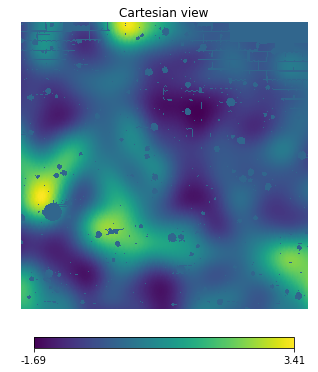

In [9]:
hp.cartview(nu_map, lonra=[0,5], latra=[0,5])

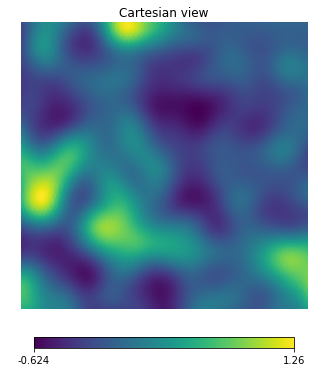

In [10]:
hp.cartview(od_map_smth, lonra=[0,5], latra=[0,5])

In [11]:
pix = np.arange(hp.nside2npix(4096))
pix_thr = pix[(nu_map>1.99)&(nu_map<2.01)]

(array([254., 229., 271., 263., 274., 262., 252., 255., 242., 247., 250.,
        261., 263., 269., 287., 257., 262., 268., 254., 251., 243., 234.,
        247., 271., 236., 266., 241., 240., 260., 245., 249., 259., 253.,
        284., 283., 250., 237., 249., 245., 248., 260., 248., 248., 260.,
        251., 268., 255., 251., 249., 260., 256., 247., 276., 278., 297.,
        260., 245., 240., 219., 257., 278., 274., 241., 269., 270., 279.,
        270., 227., 262., 246., 271., 232., 253., 261., 243., 255., 271.,
        264., 239., 251., 241., 252., 249., 246., 260., 269., 269., 247.,
        257., 256., 235., 267., 232., 256., 230., 278., 265., 228., 266.,
        247.]),
 array([0.73240328, 0.73247699, 0.73255071, 0.73262443, 0.73269814,
        0.73277186, 0.73284558, 0.73291929, 0.73299301, 0.73306673,
        0.73314044, 0.73321416, 0.73328788, 0.73336159, 0.73343531,
        0.73350903, 0.73358274, 0.73365646, 0.73373018, 0.73380389,
        0.73387761, 0.73395133, 0.73402504, 0.

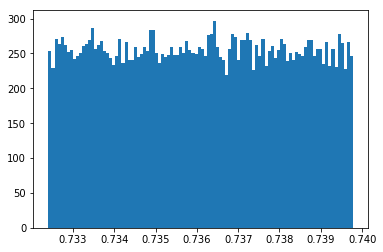

In [12]:
plt.hist(od_map_smth[pix_thr], bins=100)


In [13]:
thetaphi = np.loadtxt("/mnt/raid-cita/mlokken/buzzard/objects_for_number_density_map/des_reg/thetaphi_distMpc_{:d}_{:d}.txt".format(slice_min, slice_max))
nd_map,mean = get_nd_map(4096, thetaphi[:,0], thetaphi[:,1], mask, 35)

Mean of number density map:  0.006537977644831627
Sigma is 14.863132 arcmin (0.004324 rad) 
-> fwhm is 35.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [23]:
deg2_per_pix = hp.nside2pixarea(4096, degrees=True)*u.deg**2
ng_per_deg2 = nd_map/deg2_per_pix # number of galaxies per square degree
deg2_per_mpc2 = 1/(((cosmo.kpc_comoving_per_arcmin(z_at_value(cosmo.comoving_distance, (slice_min+slice_max)/2.*u.Mpc)))**2).to(u.Mpc**2/u.deg**2))
ng_per_mpc2 = ng_per_deg2 * deg2_per_mpc2
ng_per_mpc3 = ng_per_mpc2/(200*u.Mpc)

In [32]:
mean_per_mpc3 = mean/deg2_per_pix*deg2_per_mpc2/(200*u.Mpc)

In [33]:
mean_per_mpc3

<Quantity 0.00029519 1 / Mpc3>

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 6.000e+00, 3.000e+00, 8.000e+00, 9.000e+00, 5.000e+00,
        1.200e+01, 7.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 1.000e+01,
        9.000e+00, 1.300e+01, 1.300e+01, 1.200e+01, 8.000e+00, 1.400e+01,
        1.100e+01, 1.700e+01, 1.400e+01, 1.200e+01, 1.500e+01, 1.000e+01,
        1.300e+01, 2.000e+01, 2.200e+01, 2.900e+01, 2.100e+01, 2.400e+01,
        2.500e+01, 2.300e+01, 2.900e+01, 2.500e+01, 3.700e+01, 3.700e+01,
        4.300e+01, 3.600e+01, 3.500e+01, 3.700e+01, 4.900e+01, 4.400e+01,
        5.100e+01, 3.300e+01, 6.200e+01, 6.100e+01, 6.000e+01, 7.400e+01,
        6.700e+01, 8.900e+01, 7.700e+01, 1.020e+02, 1.070e+02, 1.240e+02,
        1.120e+02, 1.390e+02, 1.470e+0

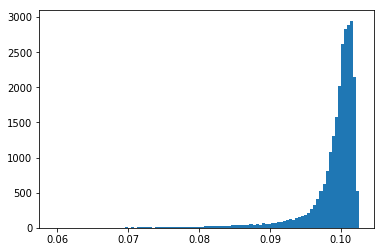

In [28]:
plt.hist(ng_per_mpc2.value[pix_thr], bins=100)

(array([1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 4.000e+00, 2.000e+00, 5.000e+00,
        4.000e+00, 6.000e+00, 3.000e+00, 8.000e+00, 9.000e+00, 5.000e+00,
        1.200e+01, 7.000e+00, 4.000e+00, 5.000e+00, 6.000e+00, 1.000e+01,
        9.000e+00, 1.300e+01, 1.300e+01, 1.200e+01, 8.000e+00, 1.400e+01,
        1.100e+01, 1.700e+01, 1.400e+01, 1.200e+01, 1.500e+01, 1.000e+01,
        1.300e+01, 2.000e+01, 2.200e+01, 2.900e+01, 2.100e+01, 2.400e+01,
        2.500e+01, 2.300e+01, 2.900e+01, 2.500e+01, 3.700e+01, 3.700e+01,
        4.300e+01, 3.600e+01, 3.500e+01, 3.700e+01, 4.900e+01, 4.400e+01,
        5.100e+01, 3.300e+01, 6.200e+01, 6.100e+01, 6.000e+01, 7.400e+01,
        6.700e+01, 8.900e+01, 7.700e+01, 1.020e+02, 1.070e+02, 1.240e+02,
        1.120e+02, 1.390e+02, 1.470e+0

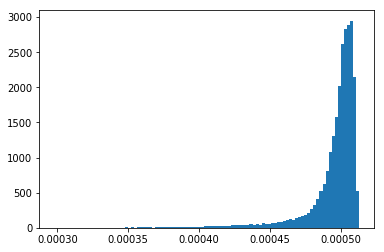

In [29]:
plt.hist(ng_per_mpc3.value[pix_thr], bins=100)

In [67]:
arcmin_per_pix = (5*u.deg).to(u.arcmin)/nd_map_img.shape[0]

In [68]:
img_ngal = cpp.ngal_convert(nd_map_img, 1332, arcmin_per_pix)

640000 13511.488655709722


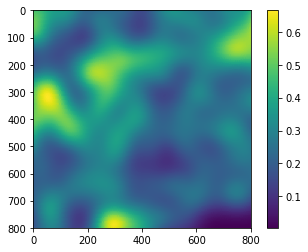

In [70]:
plt.imshow(img_ngal)
plt.colorbar()

In [72]:
plt.hist(img_ngal[pix_thr])

IndexError: index 91333558 is out of bounds for axis 0 with size 800